# Week 3 Assignment

## Introduction 

This week's assignment is to test a multiple regression model. TODO: Add more context (hypothesis)

## Data Managment

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%.2f'%x)

df = pd.read_csv('gapminder.csv')

# convert to numeric format
df['incomeperperson'] = pd.to_numeric(df['incomeperperson'], errors='coerce')
df['polityscore'] = pd.to_numeric(df['polityscore'], errors='coerce')
df['urbanrate'] = pd.to_numeric(df['urbanrate'], errors='coerce')

# listwise deletion of missing values
subset = df[['incomeperperson', 'polityscore', 'urbanrate']].dropna()

# Summarize the data
print(subset[['incomeperperson', 'urbanrate']].describe())

       incomeperperson  urbanrate
count           155.00     155.00
mean           6604.57      55.11
std            9754.98      22.41
min             103.78      10.40
25%             576.39      36.83
50%            2221.19      57.18
75%            6661.18      71.51
max           39972.35     100.00


C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


There are 155 countries in the study data set.  Economic Well-Being ranges from 103 to 39,972 US dollars with a median of 2,221 dollars.  Urbanization rate ranges from 10 to 100 percent with the average of 55 percent.

### Convert Polity Score

Since there are 21 polity score categories I chose to compress them into the 5 categories specified by the Polity IV project author's.

C:\Anaconda2\lib\site-packages\matplotlib\__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


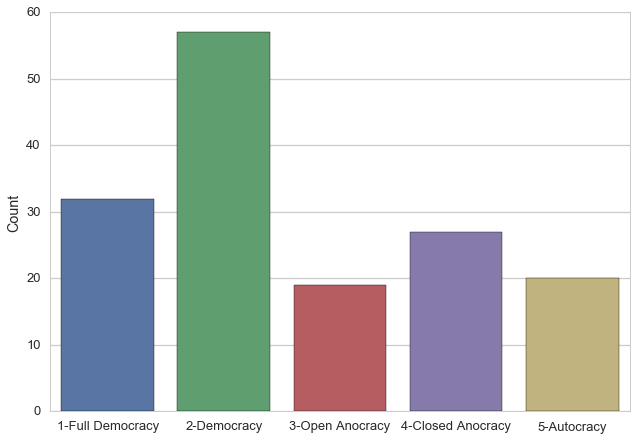

In [2]:
# This function converts the polity score to a category
def convert_polityscore_to_category(score):
    if score == 10:
        return('1-Full Democracy')
    elif score > 5:
        return('2-Democracy')
    elif score > 0:
        return ('3-Open Anocracy')
    elif score > -6:
        return ('4-Closed Anocracy')
    else:
        return('5-Autocracy')

# Now we can use the function to create the new variable
subset['SocietyType'] = subset['polityscore'].apply(convert_polityscore_to_category)
subset['SocietyType'] = subset['SocietyType'].astype('category')

# Create bar chart
sns.countplot(x='SocietyType', data=subset)
plt.ylabel('Count')
plt.xlabel('')

In [3]:
counts = subset.groupby('SocietyType').size()
print(counts)

SocietyType
1-Full Democracy     32
2-Democracy          57
3-Open Anocracy      19
4-Closed Anocracy    27
5-Autocracy          20
dtype: int64


32 of the 155 countries are full democracies.  They are the most open societies.  There are 20 autocracies in the data set.  Democracies are the most common type of society.

## Economic Well-Being, Type of Society and Urbanization Rate

Distribution of income:

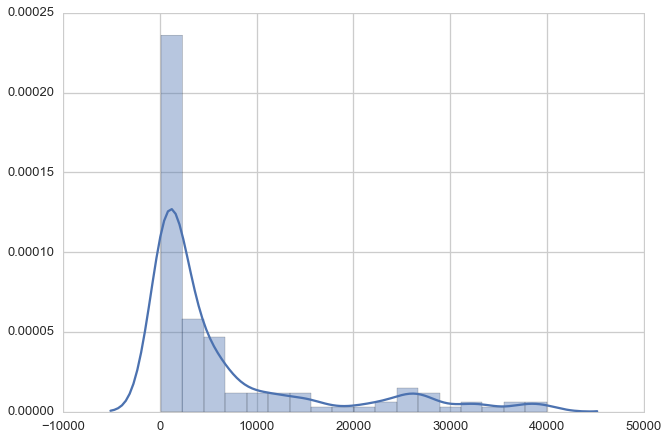

In [4]:
sns.distplot(subset['incomeperperson']);
plt.xlabel('')

median_incomeperperson = np.median(subset['incomeperperson'])


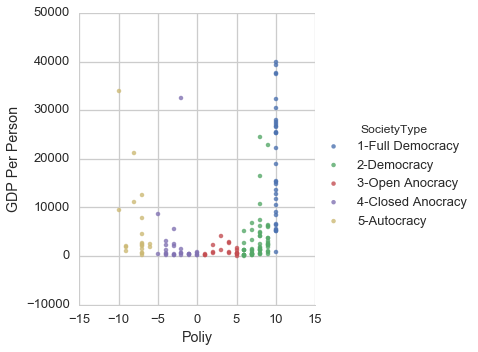

In [5]:
# This function converts the polity score to a category
def full_democracy_degree(score):
    full_democracy = score / 10
    return(full_democracy)

# Now we can use the function to create the new variable
subset['full_democracy_degree'] = subset['polityscore'].apply(full_democracy_degree)

# Visualize the relationship
sns.lmplot(x='polityscore', y='incomeperperson', data=subset, fit_reg=False, hue='SocietyType')
plt.ylabel('GDP Per Person')
plt.xlabel('Poliy')

From previous work I know that economic well-being is positively correlated with the urbanization rate of a country.  Socieites that are the most open have a higher level of urbanization.  This relationship can be readily observed in the following scatterplot:

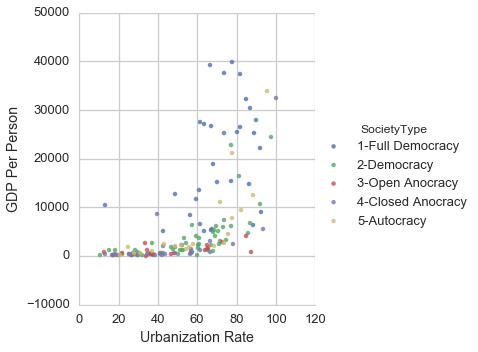

In [6]:
# Visualize the relationship
sns.lmplot(x='urbanrate', y='incomeperperson', data=subset, fit_reg=False, hue='SocietyType')
plt.ylabel('GDP Per Person')
plt.xlabel('Urbanization Rate')


# Linear Regression Model

In [7]:
# quadratic (polynomial) regression analysis
#ols_model = smf.ols('incomeperperson ~ C(SocietyType) + urbanrate ', data=subset).fit()
ols_model = smf.ols('incomeperperson ~ full_democracy_degree + urbanrate', data=subset).fit()
ols_model = smf.ols('incomeperperson ~ full_democracy_degree + urbanrate + I(full_democracy_degree**2) + I(urbanrate**2)', data=subset).fit()

print (ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        incomeperperson   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     44.20
Date:                Sat, 12 Dec 2015   Prob (F-statistic):           1.80e-24
Time:                        21:36:20   Log-Likelihood:                -1582.8
No. Observations:                 155   AIC:                             3176.
Df Residuals:                     150   BIC:                             3191.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept     

## Residual Analysis

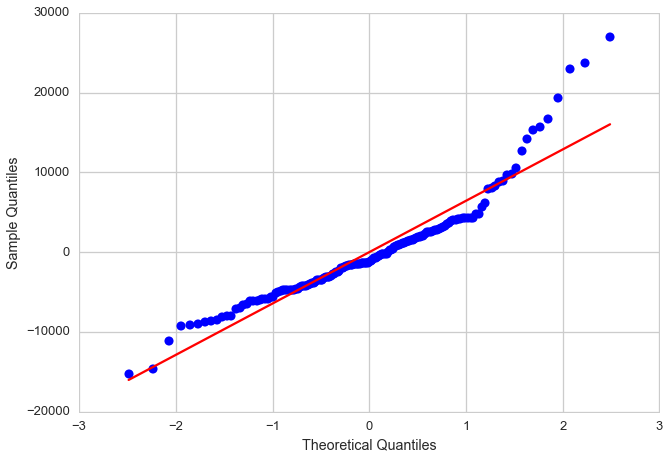

In [8]:
#Q-Q plot for normality
fig = sm.qqplot(ols_model.resid, line='r')

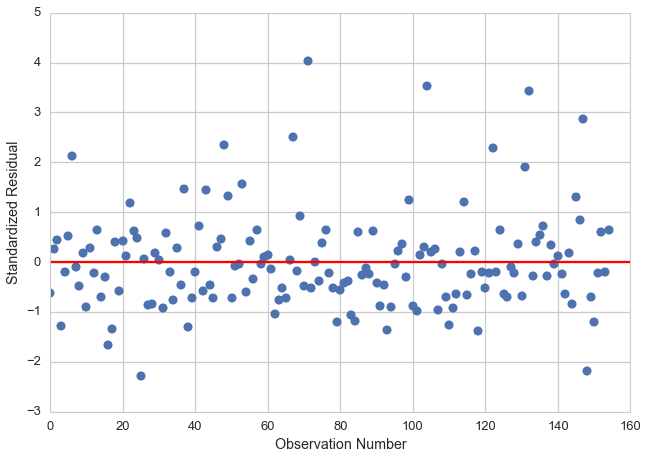

In [9]:
# simple plot of residuals
stdres=pd.DataFrame(ols_model.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

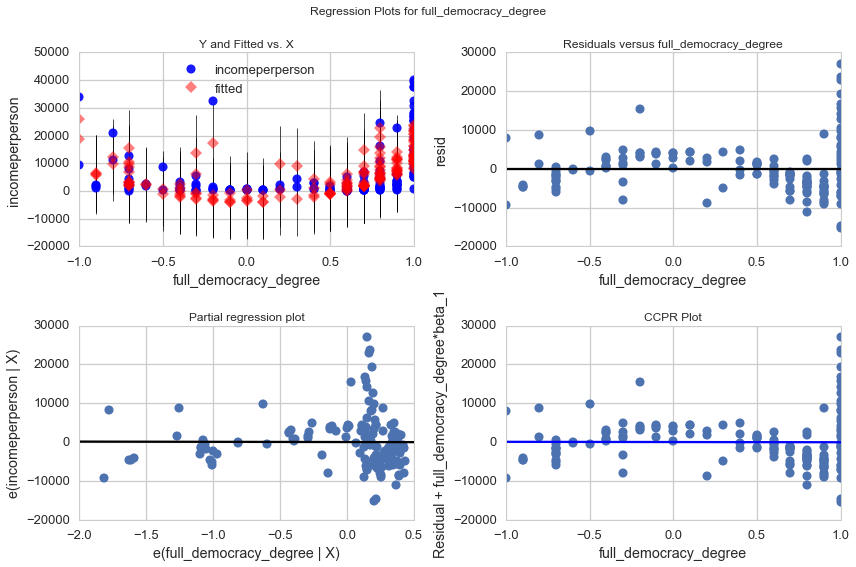

In [10]:
# additional regression diagnostic plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(ols_model, 'full_democracy_degree', fig=fig)

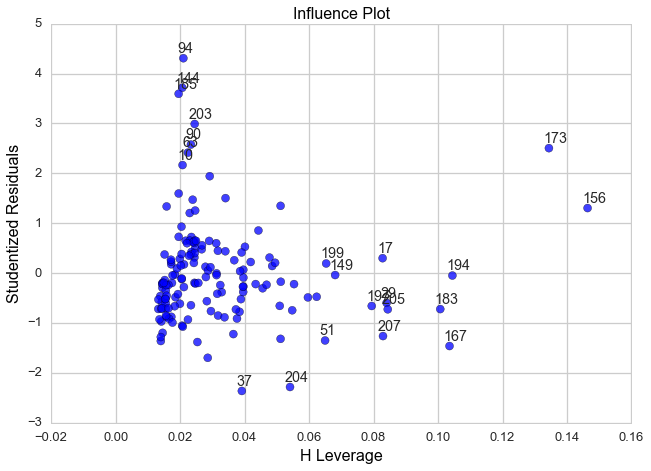

In [11]:
# leverage plot
fig = sm.graphics.influence_plot(ols_model, size=8)

# Linear Regression Without Outliers

I wanted to observe the effects of outliers on the model so using a Median Absolute Deviation outlier detection method I removed outliers from each group.  The observations labeled as outliers are displayed graphically below:

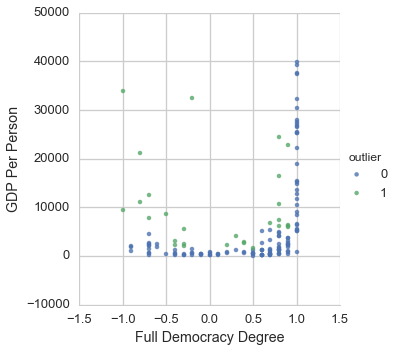

In [12]:
# Outlier detection

medians = subset.groupby('SocietyType')['incomeperperson'].agg([np.median])

def get_absolute_deviation(SocietyType, incomeperperson):
    median = medians[medians.index == SocietyType]['median']
    absolute_deviation = np.absolute(incomeperperson-median)
    return(absolute_deviation)

def get_MAD(SocietyType):
    return(MADs[MADs.index == SocietyType]['median'])
    
def is_outlier(absolute_deviations, MAD):
    threshold = 3
    if (absolute_deviations/MAD) > threshold:
        return 1
    else:
        return 0
        
subset['absolute_deviations'] = np.vectorize(get_absolute_deviation)(subset['SocietyType'], subset['incomeperperson'])
MADs = subset.groupby('SocietyType')['absolute_deviations'].agg([np.median])
subset['MAD'] = np.vectorize(get_MAD)(subset['SocietyType'])
subset['outlier'] = np.vectorize(is_outlier)(subset['absolute_deviations'], subset['MAD'])
# Get the count of outliers
subset.groupby('SocietyType')['outlier'].agg([np.sum])

# Visualize the result
sns.lmplot(x='full_democracy_degree', y='incomeperperson', data=subset, fit_reg=False, hue='outlier')
plt.ylabel('GDP Per Person')
plt.xlabel('Full Democracy Degree')

In [13]:
no_outliers = subset[subset.outlier == 0]
ols_model2 = smf.ols('incomeperperson ~ full_democracy_degree + urbanrate', data=no_outliers).fit()
print (ols_model2.summary())

                            OLS Regression Results                            
Dep. Variable:        incomeperperson   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     39.86
Date:                Sat, 12 Dec 2015   Prob (F-statistic):           4.28e-14
Time:                        21:36:25   Log-Likelihood:                -1315.0
No. Observations:                 127   AIC:                             2636.
Df Residuals:                     124   BIC:                             2645.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept             -7229.34

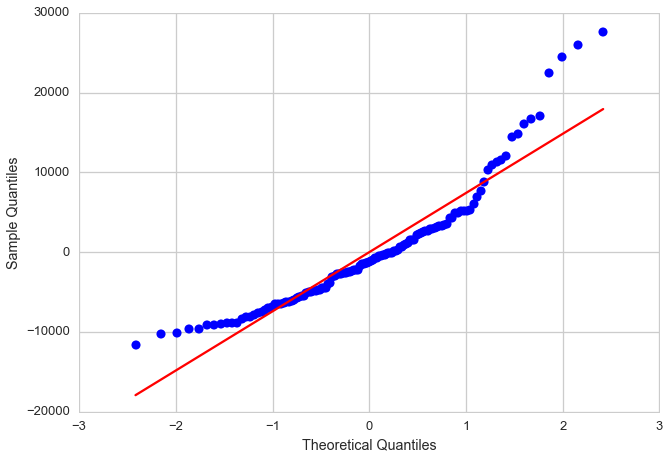

In [14]:
#Q-Q plot for normality
fig = sm.qqplot(ols_model2.resid, line='r')

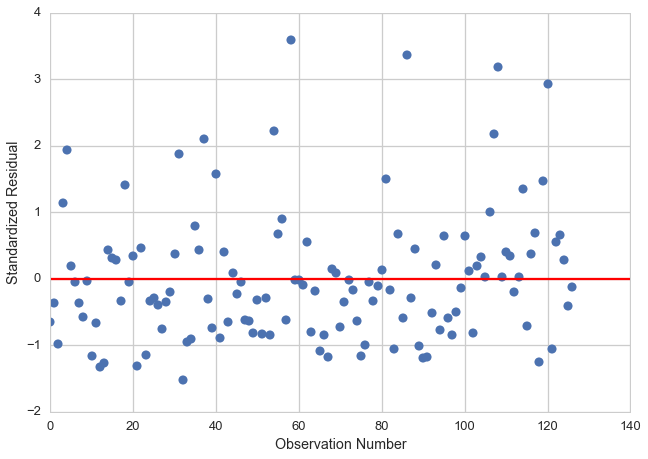

In [15]:
# simple plot of residuals
stdres=pd.DataFrame(ols_model2.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

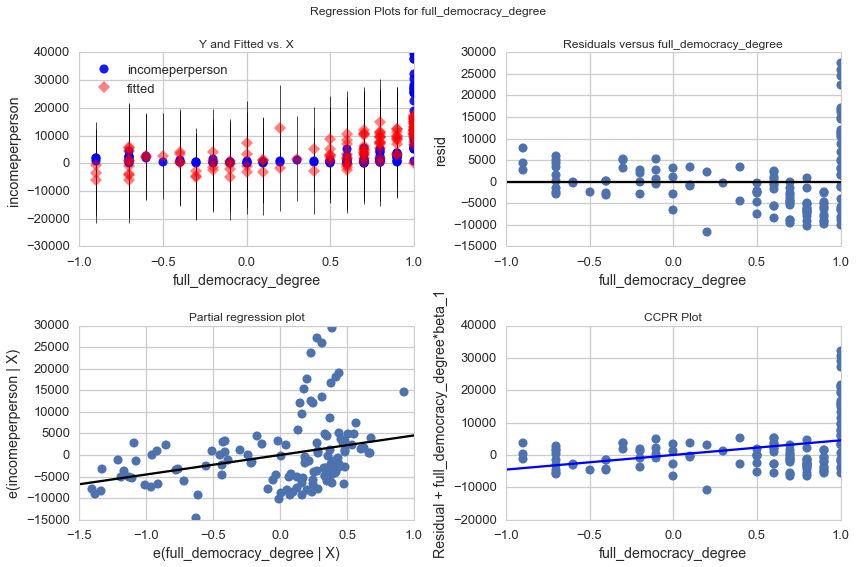

In [16]:
# additional regression diagnostic plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(ols_model2, 'full_democracy_degree', fig=fig)

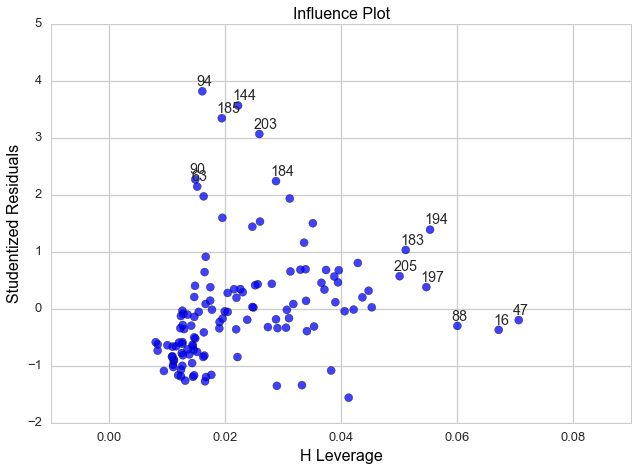

In [17]:
# leverage plot
fig = sm.graphics.influence_plot(ols_model2, size=8)

# Quadratic Regression Model

In [18]:
# quadratic (polynomial) regression analysis
#quadratic_model = smf.ols('incomeperperson ~ urbanrate + I(urbanrate**2) + C(SocietyType)', data=subset).fit()
quadratic_model = smf.ols('incomeperperson ~ I(full_democracy_degree**2) + urbanrate', data=subset).fit()
print (quadratic_model.summary())

                            OLS Regression Results                            
Dep. Variable:        incomeperperson   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     66.01
Date:                Sat, 12 Dec 2015   Prob (F-statistic):           2.32e-21
Time:                        21:36:29   Log-Likelihood:                -1594.7
No. Observations:                 155   AIC:                             3195.
Df Residuals:                     152   BIC:                             3205.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept     

TODO: Add Discussion

## Transformed Response Variable

The scaterplot shows that GDP per person is not linear so I will transform the variable.

In [19]:
subset['log_incomeperperson'] = np.log(subset.incomeperperson)
# Summarize the data
print(subset[['log_incomeperperson']].describe())

       log_incomeperperson
count               155.00
mean                  7.71
std                   1.57
min                   4.64
25%                   6.36
50%                   7.71
75%                   8.80
max                  10.60


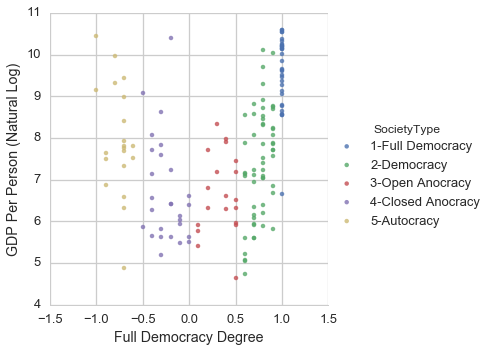

In [20]:
# Visualize the result
sns.lmplot(x='full_democracy_degree', y='log_incomeperperson', data=subset, fit_reg=False, hue='SocietyType')
plt.ylabel('GDP Per Person (Natural Log)')
plt.xlabel('Full Democracy Degree')

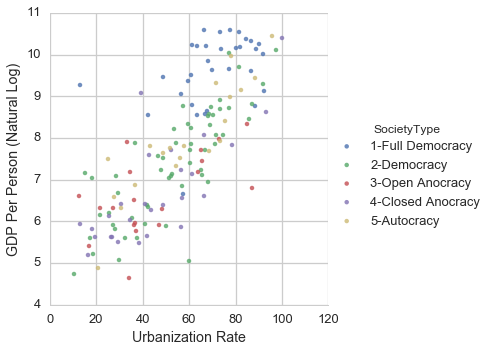

In [21]:
# Visualize the relationship
sns.lmplot(x='urbanrate', y='log_incomeperperson', data=subset, fit_reg=False, hue='SocietyType')
plt.ylabel('GDP Per Person (Natural Log)')
plt.xlabel('Urbanization Rate')

With this transformation complete I will proceed with my evaluation.

In [22]:
# linear regression analysis
model = smf.ols(formula='log_incomeperperson ~ C(SocietyType) + urbanrate', data=subset).fit()
model = smf.ols('log_incomeperperson ~ urbanrate + I(full_democracy_degree**2)', data=subset).fit()

print (model.summary())


                             OLS Regression Results                            
Dep. Variable:     log_incomeperperson   R-squared:                       0.721
Model:                             OLS   Adj. R-squared:                  0.718
Method:                  Least Squares   F-statistic:                     196.8
Date:                 Sat, 12 Dec 2015   Prob (F-statistic):           6.58e-43
Time:                         21:36:32   Log-Likelihood:                -190.65
No. Observations:                  155   AIC:                             387.3
Df Residuals:                      152   BIC:                             396.4
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Inte

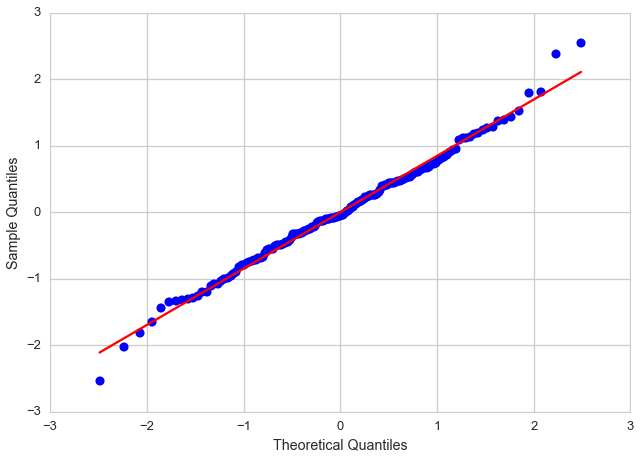

In [23]:
#Q-Q plot for normality
fig = sm.qqplot(model.resid, line='r')

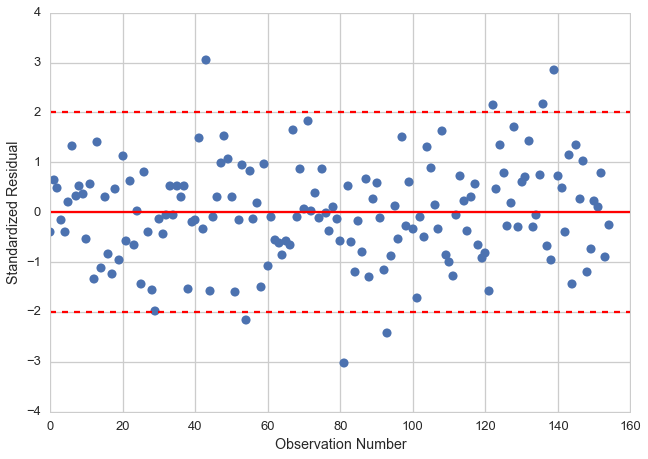

In [24]:
# simple plot of residuals
stdres=pd.DataFrame(model.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l=plt.axhline(y=0, color='r')
l=plt.axhline(y=2, color='r', ls='dashed')
l=plt.axhline(y=-2, color='r', ls='dashed')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

Figure(960x640)


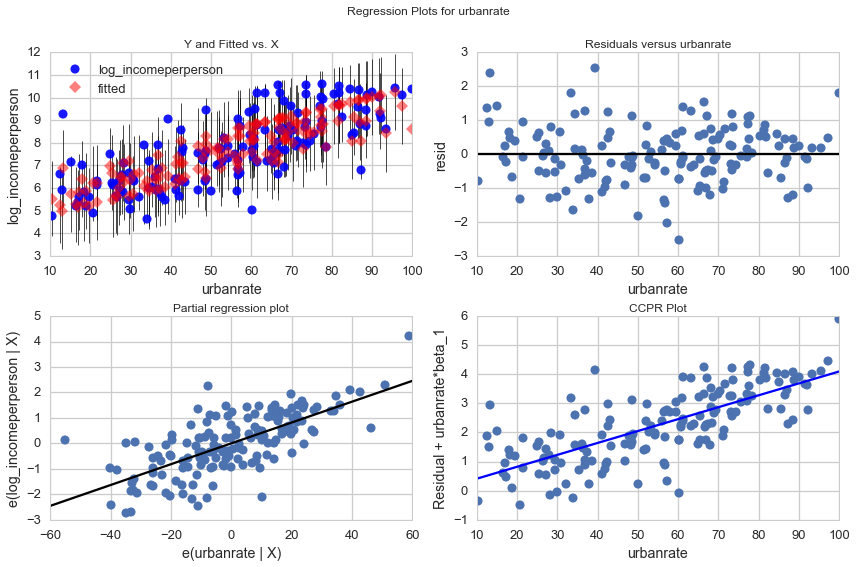

In [25]:
# additional regression diagnostic plots
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model,  "urbanrate", fig=fig)
print(fig)

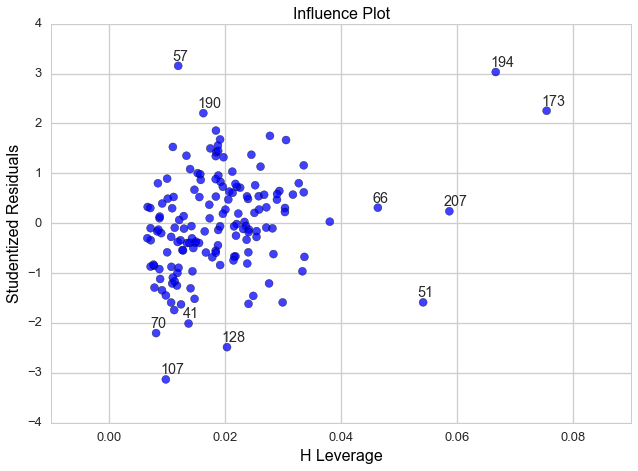

In [26]:
# leverage plot
fig = sm.graphics.influence_plot(model, size=8)

In [27]:
# linear regression analysis
no_outliers = subset[subset.outlier == 0]
model2 = smf.ols(formula='log_incomeperperson ~ full_democracy_degree + urbanrate', data=subset).fit()
print (model2.summary())

                             OLS Regression Results                            
Dep. Variable:     log_incomeperperson   R-squared:                       0.606
Model:                             OLS   Adj. R-squared:                  0.601
Method:                  Least Squares   F-statistic:                     116.9
Date:                 Sat, 12 Dec 2015   Prob (F-statistic):           1.82e-31
Time:                         21:36:36   Log-Likelihood:                -217.52
No. Observations:                  155   AIC:                             441.0
Df Residuals:                      152   BIC:                             450.2
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept           

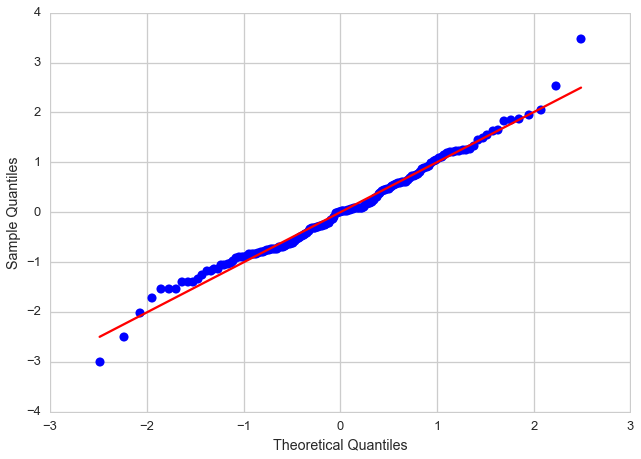

In [28]:
#Q-Q plot for normality
fig = sm.qqplot(model2.resid, line='r')

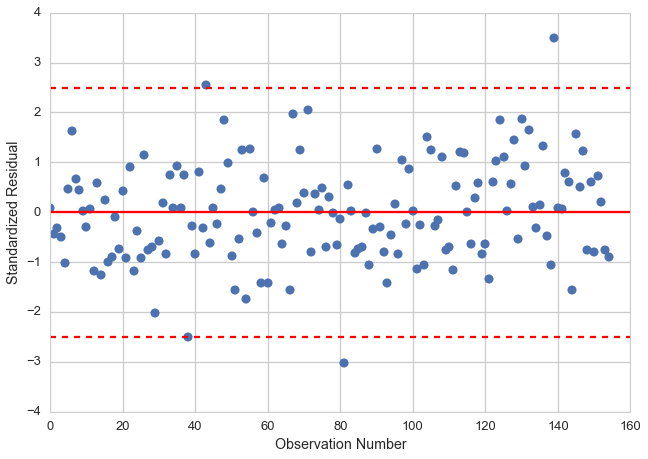

In [29]:
# simple plot of residuals
stdres=pd.DataFrame(model2.resid_pearson)
plt.plot(stdres, 'o', ls='None')
l = plt.axhline(y=0, color='r')
l=plt.axhline(y=2.5, color='r', ls='dashed')
l=plt.axhline(y=-2.5, color='r', ls='dashed')
plt.ylabel('Standardized Residual')
plt.xlabel('Observation Number')

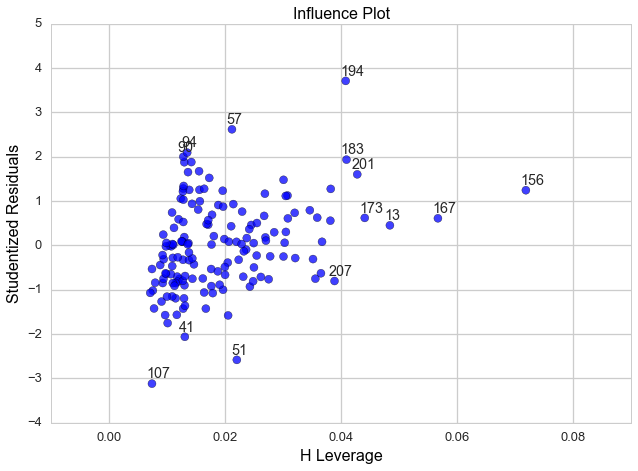

In [30]:
# leverage plot
fig = sm.graphics.influence_plot(model2, size=8)